In [71]:
from IPython.display import IFrame

import os
import numpy as np
import pandas as pd
import pickle

import config
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

## allow output of multiple values per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

In [3]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
        
    except FileNotFoundError: 
        print("File not found!")

In [4]:
def display_artist(track_info):
## create a single string with all artist names
    return " / ".join([x['name'] for x in track_info['artists']])

In [67]:
def create_artist_input_prompt(track_names, artist_names):
    user_prompt = ""
    valid_input = []
    
    for i in range(len(artist_names)):
        my_num = i
        user_prompt += f"Enter {my_num} for '{track_names[i]}' by '{artist_names[i]}'\n"
        valid_input.append(str(my_num))
    ## space is always none of the above
    user_prompt += "Enter [SPACE] for 'None of the above'\n"
    valid_input.append(" ")
    
    return valid_input, user_prompt

In [6]:
def recommend_hot_song(hot_songs_df, not_this_title):
    myrec = hot_songs_df.sample()
    
    if (myrec.title == not_this_title).all():
        print("DEBUG: try again")
        myrec = hot_songs_df.sample()
    return myrec

In [8]:
## Load hot songs df
infile_list = ['Data/db/hot/billboard_hot100_2021-02-14.csv', 
               'Data/db/hot/uk_hot100_2021-02-14.csv', 
               'Data/db/hot/hot_songs_miri.csv']

dfs = []
for fname in infile_list:
    dfs.append(pd.read_csv(fname, index_col=None))
    
hot_songs_df = pd.concat(dfs, axis=0)
hot_songs_df = hot_songs_df.drop_duplicates().reset_index(drop=True)

In [39]:
## load general songs df
indir = 'Data/db'
infile_list = os.listdir(indir)

dfs = []
for fname in infile_list:
    if fname.endswith('.csv'):
        dfs.append(pd.read_csv(os.path.join(indir, fname), index_col=None))
    
gen_songs_df = pd.concat(dfs, axis=0)
if gen_songs_df[gen_songs_df.isnull().any(axis=1)].shape[0] > 0:
    print(f"Dropping records {gen_songs_df[gen_songs_df.isnull().any(axis=1)].shape[0]} with null values")
    gen_songs_df = gen_songs_df[~gen_songs_df.isnull().any(axis=1)]
## drop dups
gen_songs_df = gen_songs_df.drop_duplicates().reset_index(drop=True)

In [48]:
gen_songs_df.shape

(51018, 5)

In [45]:
## define constants
MODEL_FEATURES = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
        'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

LABELS_COLNAME = 'k9_cluster'

In [46]:
## create cluster membership filters
clusters = np.unique(gen_songs_df[LABELS_COLNAME])
cluster_members = {}
for cluster in clusters:
    cluster_members[cluster] = np.where(gen_songs_df[LABELS_COLNAME] == cluster)

In [30]:
## get models
fitted_scaler = load("Model/big-scaler.pickle")
fitted_kmeans = load("Model/big-kmeans_9.pickle")

In [70]:
## ---- ready for user query ----
userinput_songname = input("enter song name: ")

results = sp.search(q=userinput_songname, type='track', limit=10, market="GB")

if results is None:
    print('Sorry, that track name is not recognised')
else:
    ## clarify which artist
    artist_names = [display_artist(results['tracks']['items'][i]) for i in range(len(results['tracks']['items']))]
    track_names = [results['tracks']['items'][i]['name'] for i in range(len(results['tracks']['items']))]
    valid_input, user_prompt = create_artist_input_prompt(track_names, artist_names)
    
    # continue prompting until they've entered a valid choice
    while True:
        artist_num = input(user_prompt)
        if artist_num not in valid_input:
            print(f"{artist_num} is not a valid option, try again")
        else:
            break
    
    if artist_num == ' ':  ## none of the above
        print("Sorry, this is all the tracks by this name in our database")
    else:
        # collect track details
        track_info = results['tracks']['items'][pd.to_numeric(artist_num)]

        print(f"Based on the track:\n\t{track_info['name']}")
        print(f"\tby {display_artist(track_info)}\n")

        IFrame(src="https://open.spotify.com/embed/track/"+track_info['id'],
           width="320",
           height="80",
           frameborder="0",
           allowtransparency="true",
           allow="encrypted-media",
          )

        if track_info['id'] in hot_songs_df.id.to_list():
            randhot = recommend_hot_song(hot_songs_df, selected_song.title)
            print(f"I recommend HOT song: {randhot.title.values[0]} by {randhot.pp_artist.values[0]}")
            IFrame(src="https://open.spotify.com/embed/track/"+randhot.id.values[0],
                       width="320",
                       height="80",
                       frameborder="0",
                       allowtransparency="true",
                       allow="encrypted-media",
                      )
        else:
            # recommend something similar
            ## is this track already in our database?
            if track_info['id'] in gen_songs_df.id:
                print('I know this one!')
                track_label = gen_songs_df[gen_songs_df.id == track_info.id][CLUSTERING]
            else:
                ## get the label for these audio features
                full_track_audio_features = sp.audio_features(track_info['id'])[0]
                if full_track_audio_features is None:
                    print("Error! I don't know what that song sounds like :(")
                else:
                    track_audio_features = pd.DataFrame({ky: full_track_audio_features[ky] for ky in MODEL_FEATURES},
                                                        index=[0])

                    track_audio_features_scaled = fitted_scaler.transform(track_audio_features)
                    track_audio_features_scaled_df = pd.DataFrame(track_audio_features_scaled, 
                                                                  columns = track_audio_features.columns)
                    track_label = fitted_kmeans.predict(track_audio_features_scaled_df)[0]

            randsimilar = gen_songs_df.loc[cluster_members[track_label]].sample()
            print(f"I recommend SIMILAR song (cluster {track_label}):")
            print(f"\t{randsimilar.title.values[0]}\n\tby {randsimilar.pp_artist.values[0]}")
            IFrame(src="https://open.spotify.com/embed/track/"+randsimilar.id.values[0],
                       width="320",
                       height="80",
                       frameborder="0",
                       allowtransparency="true",
                       allow="encrypted-media",
                      )

enter song name: mozart
Enter 0 for 'Mozart: Piano Sonata No. 8 in A Minor, K. 310: I. Allegro maestoso' by 'Wolfgang Amadeus Mozart / Elisabeth Leonskaja'
Enter 1 for 'Mozart: Maurerische Trauermusik, K. 477' by 'Wolfgang Amadeus Mozart / New Philharmonia Orchestra / Otto Klemperer'
Enter 2 for 'Requiem in D Minor, K. 626: 3. Sequentia: Lacrimosa - Live' by 'Wolfgang Amadeus Mozart / Berliner Philharmoniker / Claudio Abbado / Swedish Radio Choir / Kay Johannsen'
Enter 3 for 'Mozart: Piano Sonata No. 6 in D Major, K. 284: II. Rondeau en polonaise. Andante' by 'Wolfgang Amadeus Mozart / Elisabeth Leonskaja'
Enter 4 for 'Mozart: Laudate Dominum, KV 339' by 'Wolfgang Amadeus Mozart / Music Lab Collective'
Enter 5 for 'Lacrimosa' by 'Wolfgang Amadeus Mozart / Lisa Beckley / Elena Filipova / Magdaléna Hajóssyová / Peter Mikulas / Michel Piquemal / Gloria Scalchi / Michel Piquemal Vocal Ensemble / Hungarian State Opera Chorus / Oxford Schola Cantorum / Slovak Philharmonic Chorus / Hungarian 

I recommend SIMILAR song (cluster 1):
	Since I Fell For You (Featuring Mike Noyce)
	by Eau Claire Memorial Jazz I / Justin Vernon


# Song Clusters

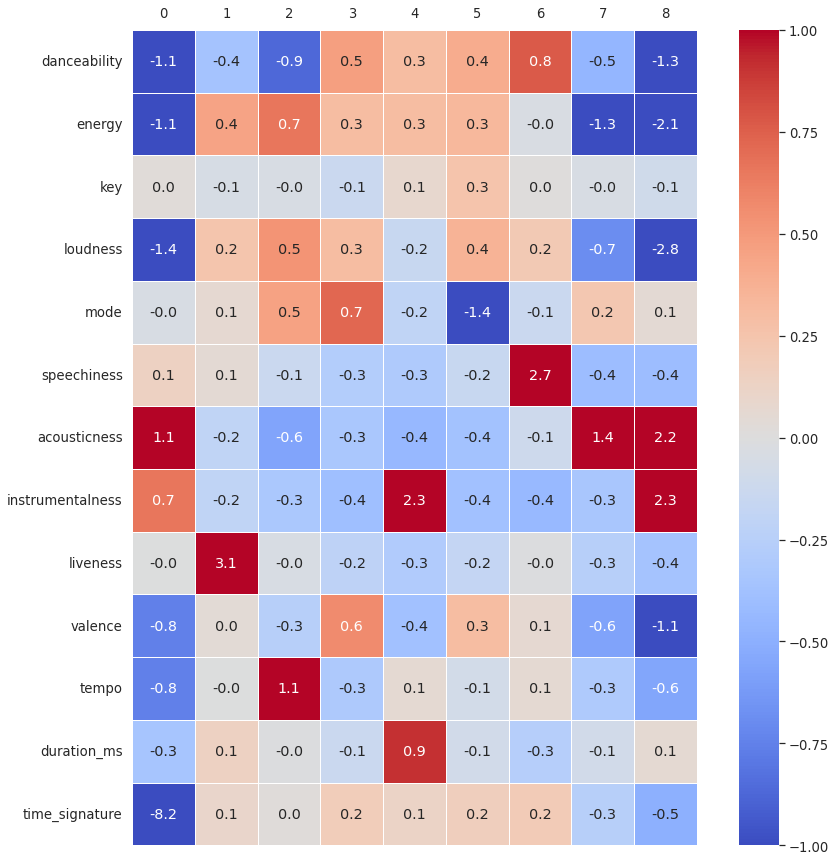

In [89]:
scaled_feature_means_by_cluster = pd.read_csv('Model/k9_scaled_feature_means_by_cluster.csv', index_col=0)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    sns.set(font_scale=1.2) 
    ax = sns.heatmap(scaled_feature_means_by_cluster.T, linewidths=.5, cmap='coolwarm', vmin=-1, vmax=1, annot=True, 
                    square=True, fmt='.1f')
    plt.tick_params(labelbottom = False, labeltop = True)

In [ ]:
cluster_descriptions=